# Introduction to Pandas, Part 2

Advanced Pandas syntax, aggregation, and joining.

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from IPython.display import display

plt.style.use('fivethirtyeight')
sns.set_context("notebook")

Let's start by loading the California baby names again.

In [ ]:
import urllib.request
import os.path
import zipfile

data_url = "https://www.ssa.gov/oact/babynames/state/namesbystate.zip"
local_filename = "babynamesbystate.zip"
if not os.path.exists(local_filename): # if the data exists don't download again
    with urllib.request.urlopen(data_url) as resp, open(local_filename, 'wb') as f:
        f.write(resp.read())

zf = zipfile.ZipFile(local_filename, 'r')

ca_name = 'CA.TXT'
field_names = ['State', 'Sex', 'Year', 'Name', 'Count']
with zf.open(ca_name) as fh:
    babynames = pd.read_csv(fh, header=None, names=field_names)

babynames.sample(5)

Goal 1: Find the most popular baby name in California in 2018

In [ ]:
babynames[babynames["Year"] == 2018].sort_values(by = "Count", ascending = False).head(5)

In [ ]:
babynames[babynames["Year"] == 2018].sort_values(by = "Count").tail(5)

## Goal 2: Find baby names that start with j. 

### Approach 1: Combine lecture 4 syntax with CS61A/CS88 ideas.

In [ ]:
babynames["Name"].head(20)

In [ ]:
starts_with_j = [ x.startswith('J') for x in babynames["Name"]]
#starts_with_j = [ x[0] == 'J'       for x in babynames["Name"]]  # Alternative. Why?
starts_with_j[:20]

In [ ]:
starts_with_j = [x.startswith('J') for x in babynames["Name"]]
babynames[starts_with_j].sample(5)

In [ ]:
j_names = babynames[ [x.startswith('J') for x in babynames["Name"]] ]

### Approach 2: Use the Series.str methods.

First, what are these special `str` things in there??

In [ ]:
s = babynames["Name"].str
n = "Jane" # a Simple string, so we can compare...

In [ ]:
s  # Let's look at s, and then use <TAB> on `s.` to get a sense of what's there...

In [ ]:
babynames["Name"].str.startswith('J').head(10)

In [ ]:
starts_with_j = babynames["Name"].str.startswith('J')
starts_with_j.head(10)

In [ ]:
babynames[babynames["Name"].str.startswith('J')].sample(5)

**Quick detour** - which option performs better?

In [ ]:
%timeit [x[0] == 'J' for x in babynames["Name"]]
%timeit [x.startswith('J') for x in babynames["Name"]]
%timeit babynames["Name"].str.startswith('J')

In [ ]:
babynames[babynames["Name"].str.contains('ad')].sample(5)

In [ ]:
babynames["Name"].str.split('a').to_frame().head(5)

### In-lecture challenge

Try to write a line of code that creates a list (or Series or array) of all names that end with “ert”.

<details>
    <summary>Answer</summary>
    <pre>
    babynames[babynames["Name"].str.endswith('ert')]["Name"].unique()
    </pre>
</details>

---

## Goal 3: Sort names by their length.

Suppose we want to sort all baby names in California by their length.

As before, there are ways to do this using only lecture 4 content. For example, the montrosity below was concocted during the Sp19 version of this class.

In [ ]:
babynames.iloc[[i for i, m in sorted(enumerate(babynames['Name']), key=lambda x: -len(x[1]))]].head(5)

### Approach 1: Create a temporary column.

Create a new series of only the lengths. Then add that series to the dataframe as a column. Then sort by that column. Then drop that column.

In [ ]:
#create a new series of only the lengths
babyname_lengths = babynames["Name"].str.len()

#add that series to the dataframe as a column
babynames["name_lengths"] = babyname_lengths
babynames.head(5)

In [ ]:
#sort by the temporary column
babynames = babynames.sort_values(by = "name_lengths", ascending=False)
babynames.head(25)

In [ ]:
#drop the temporary column
babynames = babynames.drop("name_lengths", axis = 'columns')
babynames.head(5)

We can also use the Python map function if we want to use an arbitrarily defined function. Suppose we want to sort by the number of occurrences of "dr" plus the number of occurences of "ea".

In [ ]:
def dr_ea_count(string):
    return string.count('dr') + string.count('ea')

#create the temporary column
babynames["dr_ea_count"] = babynames["Name"].map(dr_ea_count)

#sort by the temporary column
babynames = babynames.sort_values(by = "dr_ea_count", ascending=False)
babynames.head()

In [ ]:
#drop that column
babynames = babynames.drop("dr_ea_count", 1)
babynames.head(5)

### Approach 2: Generate an index sorted in the desired order.

In [ ]:
#let's start over by first scrambling the order of babynames
babynames = babynames.sample(frac=1)
babynames.head(5)

Another approach is to take advantage of the fact that `.loc` can accept an index. That is:
 + `df.loc[idx]` returns df with its rows in the same order as the given index.
 + Only works if the index exactly matches the DataFrame.

The first step was to create a sequence of the lengths of the names.

In [ ]:
name_lengths = babynames["Name"].str.len()
name_lengths.head(5)

The next step is to sort the new series we just created.

In [ ]:
name_lengths_sorted_by_length = name_lengths.sort_values()
name_lengths_sorted_by_length.head(5)

Next, we pass the index of the sorted series to the loc method of the original dataframe.

In [ ]:
index_sorted_by_length = name_lengths_sorted_by_length.index
index_sorted_by_length

In [ ]:
babynames.loc[index_sorted_by_length].tail(5)

Note we can also do this all in one line:

In [ ]:
babynames.loc[babynames["Name"].str.len().sort_values().index].head(5)

---

### Goal 4: Name whose popularity has changed the most. 

First we need to define change in popularity. 

For the purposes of lecture, let’s stay simple and use the AMMD (absolute max/min difference): max(count) - min(count). 

To make sure we understand this quantity, let's consider the name Jennifer.

In [ ]:
jennifer_counts = babynames.query("Name == 'Jennifer'")["Count"]
jennifer_counts.head(5)

The AMMD for Jennifer is 6,059, as seen below:

In [ ]:
max(jennifer_counts) - min(jennifer_counts)

In [ ]:
def ammd(series):
    return max(series) - min(series)

In [ ]:
ammd(jennifer_counts)

In [ ]:
ammd(babynames.query("Name == 'Jessica'")["Count"])

### Approach 1: Naive For Loop

As a first approach, we can try to use a for loop.

In [ ]:
#build dictionary where entry i is the ammd for the given name
#e.g. ammd["jennifer"] should be 6059
ammd_of_babyname_counts = {}
for name in babynames["Name"].unique()[0:10]:
    counts_of_current_name = babynames[babynames["Name"] == name]["Count"]
    ammd_of_babyname_counts[name] = ammd(counts_of_current_name)
    
#convert to series
ammd_of_babyname_counts = pd.Series(ammd_of_babyname_counts) 
ammd_of_babyname_counts

Answer below. Note that we only used the first 100 names because otherwise the code takes ages to complete running.

In [ ]:
#build dictionary where entry i is the ammd for the given name
#e.g. ammd["jennifer"] should be 6059
ammd_of_babyname_counts = {}
for name in sorted(babynames["Name"].unique())[0:100]:
    counts_of_current_name = babynames[babynames["Name"] == name]["Count"]
    ammd_of_babyname_counts[name] = ammd(counts_of_current_name)
    
#convert to series
ammd_of_babyname_counts = pd.Series(ammd_of_babyname_counts) 
ammd_of_babyname_counts.head(5)

### Approach 2: Use groupby.agg

Instead, we can use the very powerful groupby.agg operation, which allows us to simply and efficiently compute what we want.

In [ ]:
babynames.groupby("Name").agg(max).head(5)

In [ ]:
babynames.head()

In [ ]:
%%time
babynames.groupby("Name").agg(ammd).head(5)

Note that the result includes both a Year and Count column. The Count column is what we want, namely the AMMD for the name in that row. To check your understanding, try to figure out what the Year column represents.

To understand how groupby works, consider the visual diagram below. The `groupby` function clusters rows from the original dataframe into groups (which I call subframes). The `agg` function then condenses each subframe into a single representative row using the provided function f.

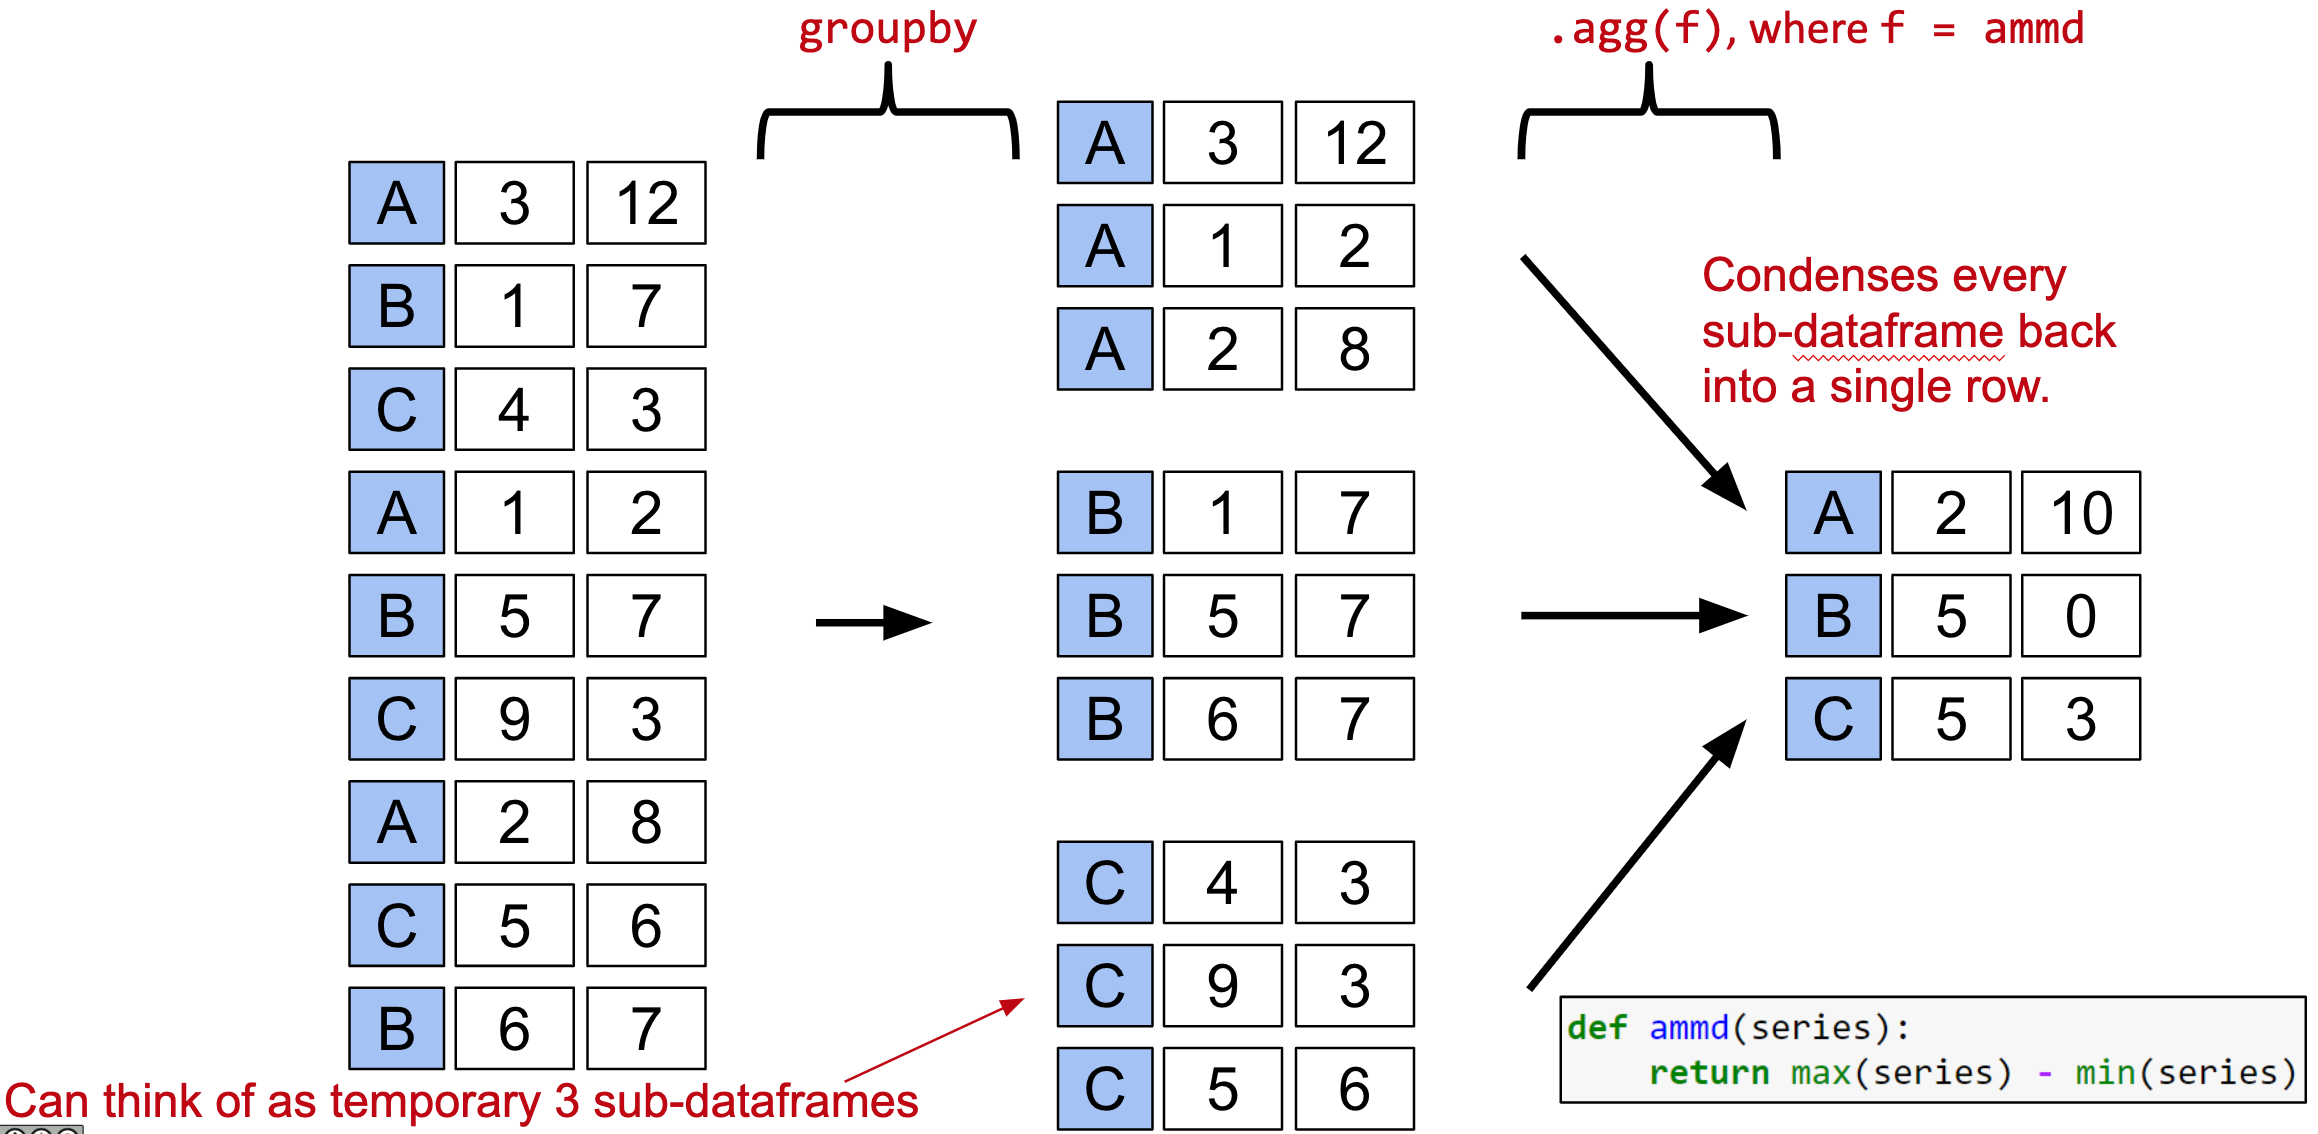

Let's actually build this DataFrame and play with it interactively to understand `groupby` a little better:

In [ ]:
d = pd.DataFrame(dict(x=[3,1,4,1,5,9,2,5,6], y=[12,7,3,2,7,3,8,6,7]), index=list('ABCABCACB') )
d

In [ ]:
dgb = d.groupby(d.index)
dgb

In [ ]:
dgb.groups

In [ ]:
dgb.groups['A']

In [ ]:
dgb.get_group('A')

In [ ]:
dgb.agg(ammd)

---

## Some Additional Groupby Puzzles

Groupby puzzle #1: To test your understanding, try to interpret the result of the code below.

In [ ]:
babynames.head(5)

In [ ]:
babynames.groupby("Year").agg(ammd).plot();

In [ ]:
for i, (k, v) in enumerate(babynames.groupby("Year")):
    if i >= 3: break
    print(f"Year: {k}")
    display(v.head())

For reference, the first 5 values from the plot above are:

In [ ]:
babynames.groupby("Year").agg(ammd).head(5)

#### groupby Puzzle #2

In [ ]:
elections = pd.read_csv("elections.csv")
elections.sample(5)

We have to be careful when using aggregation functions. For example, the code below might be misinterpreted to say that Woodrow Wilson ran for election in 2016. Why is this happening?

elections.groupby("Party").agg(max).head(10)

In [ ]:
elections.groupby("Party").agg(max).head(10)

### groupby puzzle #3

Inspired by above, try to predict the results of the groupby operation shown. The answer is below the image.

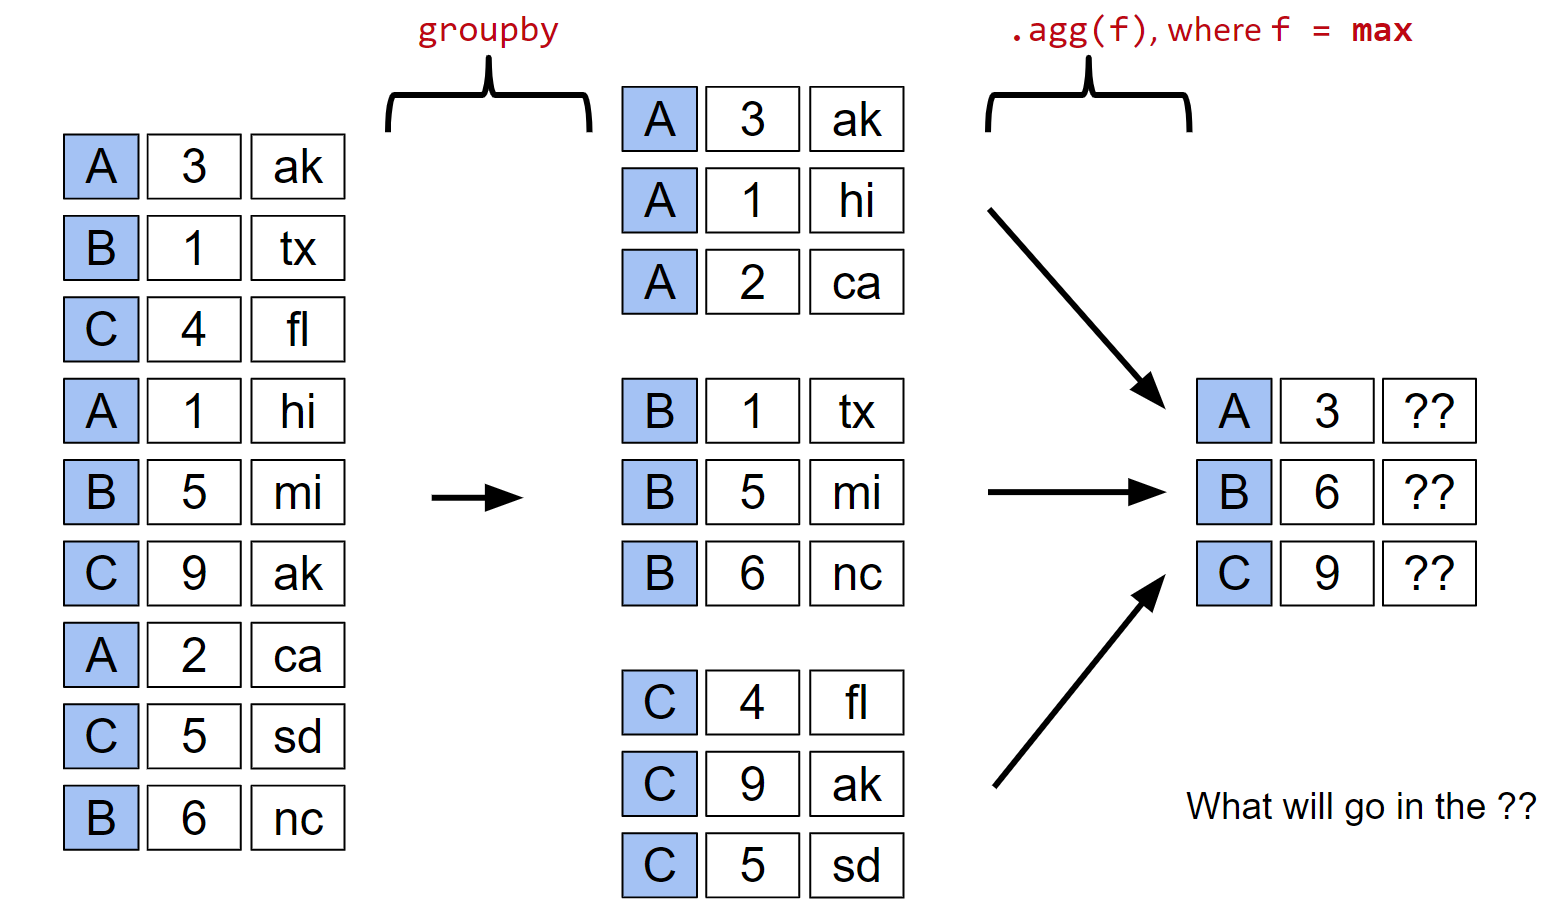

The top ?? will be "hi", the second ?? will be "tx", and the third ?? will be "sd". 

In [ ]:
ds = pd.DataFrame(dict(x=[3,1,4,1,5,9,2,5,6], 
                      y=['ak', 'tx', 'fl', 'hi', 'mi', 'ak', 'ca', 'sd', 'nc']), 
                      index=list('ABCABCACB') )
ds

In [ ]:
ds.groupby(ds.index).agg(max)

### groupby puzzle #4

Next we'll write code that properly returns _the best result by each party_. That is, each row should show the Year, Candidate, Popular Vote, Result, and % for the election in which that party saw its best results (rather than mixing them as in the example above), here's what the first rows of the correct output should look like:

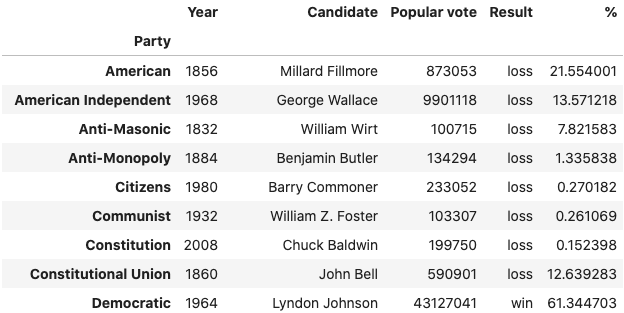

In [ ]:
elections_sorted_by_percent = elections.sort_values("%", ascending=False)
elections_sorted_by_percent.head(5)

In [ ]:
#def get_first(s):
#    return s.iloc[0]
    
elections_sorted_by_percent = elections.sort_values("%", ascending=False)
elections_sorted_by_percent.groupby("Party").agg(lambda x : x.iloc[0]).head(10)

You'll soon discover that with Pandas' rich tool set, there's typically more than one way to get to the same answer. Each approach has different tradeoffs in terms of readability, performance, memory consumption, complexity and more.  It will take some experience for you to develop a sense of which approach is better for each problem, but you should in general try to think if you can at least envision a different solution to a given problem, especially if you find your current solution to be particularly convoluted or hard to read.

Here's a couple of other ways of obtaining the same result (in each case we only show the top part with `head()`).  The first approach uses `groupby` but finds the location of the maximum value via the `idxmax()` method (look up its documentation!).  We then index and sort by party to match the requested formatting:

In [ ]:
elections.head()

In [ ]:
elections.groupby('Party')['%'].idxmax()

In [ ]:
best_per_party = elections.loc[elections.groupby('Party')['%'].idxmax()]  # This is the computational part
best_per_party.set_index('Party').sort_index().head()  # This indexes by Party to match the formatting above

And this one doesn't even use `groupby`! This approach instead uses the `drop_duplicates` method to keep only the last occurrence of of each party after having sorted by "%", which is the best performance.  Again, the 2nd line is purely formatting:

In [ ]:
best_per_party2 = elections.sort_values('%').drop_duplicates(['Party'], keep='last')
best_per_party2.set_index('Party').sort_index().head()  # Formatting

*Challenge:* see if you can find yet another approach that still gives the same answer.

---

## Other groupby Features

### groupby.size()

In [ ]:
elections.groupby("Party")

In [ ]:
#size returns a Series giving the size of each group
elections.groupby("Party").size().head(15)

### groupby.filter()

In [ ]:
# filter gives a copy of the original DataFrame where row r is included
# if its group obeys the given condition
#
# Note: Filtering is done per GROUP, not per ROW.
elections.groupby("Year").filter(lambda sf: sf["%"].max() < 45)

In [ ]:
for i, (n, g) in enumerate(elections.groupby("Party")):
    print(n)
    display(g.head(2))
    if i>3: break

### groupby.sum(), groupby.mean(), etc.

As an alternative to groupby.agg(sum), we can also simply do groupby.sum().

In [ ]:
elections.groupby("Year").agg(sum).head()

In [ ]:
elections.groupby("Year").sum().head()

The same applies for many other common operations.

In [ ]:
elections.groupby("Year").agg(max).head()

In [ ]:
elections.groupby("Year").max().head()

In [ ]:
#elections.groupby("Year").mean().head()
#elections.groupby("Year").median().head()
elections.groupby("Year").max().head()

## Pivot Tables

It is possible to group a DataFrame by multiple features. For example, if we group by Year and Sex we get back a DataFrame with the total number of babies of each sex born in each year.

In [ ]:
babynames.groupby(["Year", "Sex"]).agg(sum).head(6)

In [ ]:
babynames.groupby(["Sex", "Year"]).agg(sum).head(6)

In [ ]:
babynames.head(10)

In [ ]:
babynames.groupby(["Count", "Year", "Sex"]).agg(sum).head(6)

The DataFrame resulting from the aggregation operation is now multi-indexed. That is, it has more than one dimension to its index. We will explore this in next week's exercises.

### Goal 5: Finding the number of babies born in each year of each sex.

Suppose we want to build a table showing the total number of babies born of each sex in each year. One way is to groupby using both columns of interest.

In [ ]:
babynames.groupby(["Year", "Sex"]).agg(sum).head(6)

A more natural approach is to use a pivot table (like we saw in data 8).

In [ ]:
babynames.head(5)

In [ ]:
babynames_pivot = babynames.pivot_table(
    index='Year', # the rows (turned into index)
    columns='Sex', # the column values
    values=['Count', 'Name'], # the field(s) to processed in each group
    aggfunc=np.max, # group operation
)
babynames_pivot.head(6)

The basic idea behind pivot tables is shown in the image below.

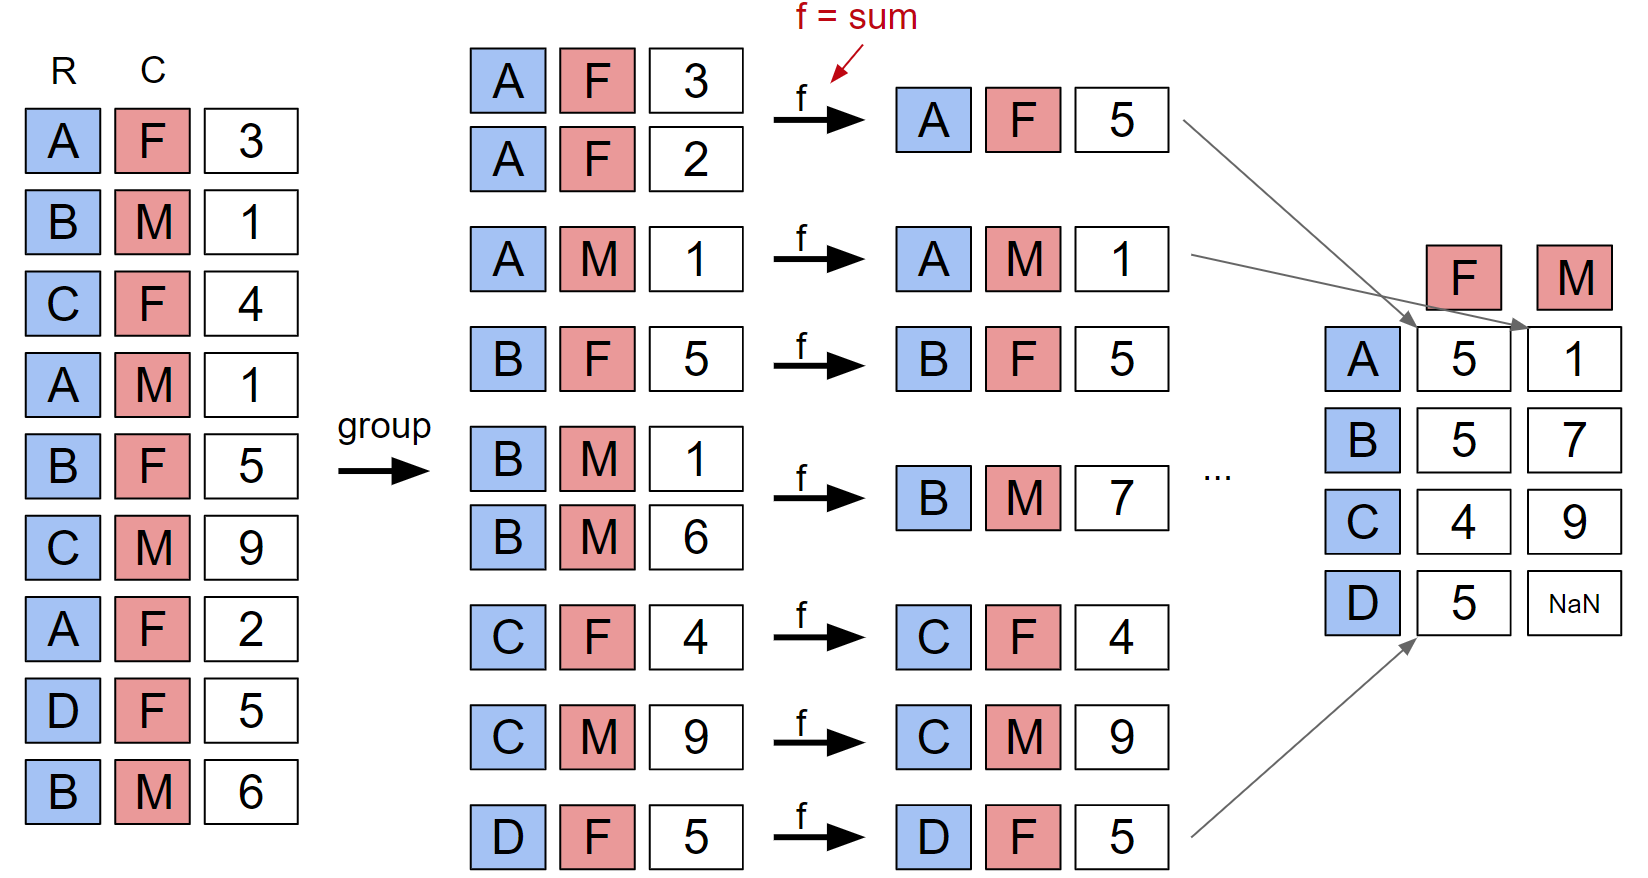

### Extra Groupby Puzzle

### groupby puzzle #5:  More careful look at the most popular 2018 name in California.

In goal 1, we didn't take into account the unlikely possibility that the most popular name was actually spread across both birth sexes. For example, what if in the table below it turns out that there were 300 female Noahs born in CA in 2018. In that case, Noah would actually be the most popular.

Since our queries are getting pretty long, I've stuck them inside parentheses which allows us to spread them over many lines.

In [ ]:
(
babynames[babynames["Year"] == 2018]
    .sort_values(by = "Count", ascending = False)
    .head(5)
)

Try to add a single line to the operation above so that each row represents the sum of male and female babies born in 2018 with that name. To do this, fill in the ??? below.

In [ ]:
(
babynames[babynames["Year"] == 2018]
    #.???
    .sort_values(by = "Count", ascending = False)
    .head(5)
)

In [ ]:
def ammd2(L):
    return max(L) - min(L)

print(ammd2([1, 2, 3, 4, 5]))

In [ ]:
ammd2 = lambda L: max(L) - min(L)
print(ammd2([1, 2, 3, 4, 5]))